## TF reporter activity analysis


### Figure 6 - Reporter confidence levels

---
Load libraries

In [1]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['pdf.use14corefonts'] = True # Edit text in Adobe Illustrator

/tmp/ipykernel_1043202/4006928364.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data**

In [2]:
# Import processed bc counts from the preprocessing step
cDNA_df = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv")

# We are not going to use NIH3T3 data, so remove it for now
cDNA_df = cDNA_df[cDNA_df['cell'] != "NIH3T3"]

# Rename stimulation status of control conditions
cDNA_df['stimulation'].fillna("no", inplace=True)

# Load RNA data
tf_rna = pd.read_csv("/DATA/usr/m.trauernicht/data/RNA_seq/rna_tpm_all_tfs.tsv", sep='\t')
rna_correlations = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/rna_correlations.tsv", sep='\t')

# Load other pre-processed data
on_target_activities = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/on_target_activities.tsv", sep='\t')
off_target_activities = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/off_target_activities.tsv", sep='\t')
cDNA_df_TF4 = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/cDNA_df_TF4.tsv", sep='\t')
chosen_conditions = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/chosen_conditions.tsv", sep='\t')

In [15]:
chosen_conditions[90:100]

,tf,condition,tf_condition
90,TFCP2L1,mES_NT,TFCP2L1_mES_NT
91,TFEB,mES_Pou5f1_ctrl,TFEB_mES_Pou5f1_ctrl
92,THRA,HEK293,THRA_HEK293
93,THRB,HEK293,THRB_HEK293
94,TP53,A549_Nutlin,TP53_A549_Nutlin
95,VDR::RXRA,U2OS_Calcitriol,VDR::RXRA_U2OS_Calcitriol
96,WT1,U2OS,WT1_U2OS
97,XBP1,MCF7,XBP1_MCF7
98,ZFP42,mES_NT,ZFP42_mES_NT
99,ZFX,mES_Dox,ZFX_mES_Dox


---
**Pre-process data**

In [84]:
# Filter cDNA_df
reference_activities = cDNA_df[(cDNA_df['neg_ctrls'] == "No") & 
                               (cDNA_df['hPGK'] == "No") & 
                               (~cDNA_df['tf'].str.contains("RANDOM")) & 
                               (cDNA_df['native_enhancer'] == "No")]

# Select distinct columns and mutate reporter_activity_minP
reference_activities = reference_activities[['tf', 'condition', 'reporter_id', 'commercial_reporter', 'reporter_activity_minP']].drop_duplicates()
reference_activities['reporter_activity_minP'] = np.log2(reference_activities['reporter_activity_minP'])

# Mutate tf and tf_condition
reference_activities['tf'] = reference_activities['tf'].str.split("_").str[0]
reference_activities['tf_condition'] = reference_activities['tf'] + "_" + reference_activities['condition']

# Filter based on chosen_conditions
reference_activities = reference_activities[reference_activities['tf_condition'].isin(chosen_conditions['tf_condition'])]
reference_activities = reference_activities.drop(columns='tf_condition')

# Join with rna_correlations and off_target_activities
cDNA_df6 = pd.merge(reference_activities, rna_correlations, how='left')
off_target_activities_2 = off_target_activities[['reporter_id', 'tf', 'commercial_reporter', 'reporter_dif_minP', 'condition', 'effect_size']].rename(columns={'reporter_dif_minP' : 'off_target_activity', 'condition' : 'off_target_perturbation'})
cDNA_df6 = pd.merge(cDNA_df6, off_target_activities_2, how='left', on=['reporter_id', 'tf', 'commercial_reporter'])

# Mutate off_target_activity
cDNA_df6['off_target_activity'] = np.where(cDNA_df6['effect_size'] == 1, -cDNA_df6['off_target_activity'], cDNA_df6['off_target_activity'])
cDNA_df6['off_target_activity'] = np.where((cDNA_df6['off_target_activity'] > 0) & (~cDNA_df6['off_target_activity'].isna()), 0, cDNA_df6['off_target_activity'])
cDNA_df6 = cDNA_df6.drop(columns='effect_size')

# Join with on_target_activities
on_target_activities_2 = on_target_activities[['reporter_id', 'tf', 'commercial_reporter', 'reporter_dif_minP', 'condition', 'effect_size']].rename(columns={'condition' : 'perturbation_condition'})
cDNA_df6 = pd.merge(cDNA_df6, on_target_activities_2, how='left', on=['reporter_id', 'tf', 'commercial_reporter'])

# Mutate reporter_dif_minP
cDNA_df6['reporter_dif_minP'] = np.where(cDNA_df6['effect_size'] == 0, -cDNA_df6['reporter_dif_minP'], cDNA_df6['reporter_dif_minP'])
cDNA_df6 = cDNA_df6.drop(columns='effect_size')

# Calculate quality_score
cDNA_df6['quality_score'] = cDNA_df6[['reporter_dif_minP', 'reporter_activity_minP', 'cor_pval', 'off_target_activity']].sum(axis=1)
cDNA_df6['quality_score'] = np.where(cDNA_df6['quality_score'] < 0, 0, cDNA_df6['quality_score'])

# Group by tf and arrange by pval_adj
lm_pval = cDNA_df_TF4.sort_values('pval_adj').groupby('tf').first().reset_index()
lm_pval = lm_pval[['tf', 'pval_adj']].drop_duplicates()

cDNA_df_confidence2 = cDNA_df6.copy()
cDNA_df_confidence2['active'] = np.where(cDNA_df_confidence2['reporter_activity_minP'] > 1, "Yes", "No")
cDNA_df_confidence2['n_active'] = cDNA_df_confidence2.groupby('tf')['active'].transform('count')
cDNA_df_confidence2['n_active'] = np.where(cDNA_df_confidence2['active'] == "No", 0, cDNA_df_confidence2['n_active'])
cDNA_df_confidence2['n_active'] = cDNA_df_confidence2.groupby('tf')['n_active'].transform('max')
cDNA_df_confidence2 = cDNA_df_confidence2.merge(lm_pval, on='tf', how='left')
cDNA_df_confidence2['conf_level'] = np.where(((cDNA_df_confidence2['commercial_reporter'] == "No") & (cDNA_df_confidence2['pval_adj'] < 0.05) & (cDNA_df_confidence2['reporter_activity_minP'] > 1)) |
                                             ((cDNA_df_confidence2['commercial_reporter'] == "No") & (cDNA_df_confidence2['n_active'] > 12) & (cDNA_df_confidence2['reporter_activity_minP'] > 1)) |
                                             ((cDNA_df_confidence2['commercial_reporter'] == "Yes") & (cDNA_df_confidence2['reporter_activity_minP'] > 1)), 1, 0)
cDNA_df_confidence2['conf_level'] = np.where((cDNA_df_confidence2['cor_pval'] > 1) & (~cDNA_df_confidence2['cor_pval'].isna()), cDNA_df_confidence2['conf_level'] + 1, cDNA_df_confidence2['conf_level'])
cDNA_df_confidence2['conf_level'] = np.where((cDNA_df_confidence2['reporter_dif_minP'] > 1) & (~cDNA_df_confidence2['reporter_dif_minP'].isna()), cDNA_df_confidence2['conf_level'] + 2, cDNA_df_confidence2['conf_level'])
cDNA_df_confidence2['conf_level'] = np.where((cDNA_df_confidence2['conf_level'] >= 1) & (cDNA_df_confidence2['off_target_activity'] < -1) & (~cDNA_df_confidence2['off_target_activity'].isna()), cDNA_df_confidence2['conf_level'] - 1, cDNA_df_confidence2['conf_level'])

reporter_features = cDNA_df[['promoter', 'spacing', 'distance', 'background', 'tf', 'reporter_id']].drop_duplicates()

## Export cDNA_df_confidence2
cDNA_df_confidence2.to_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/cDNA_df_confidence2.tsv", sep='\t', index=False)


TypeError: '_DendrogramPlotter' object does not support item assignment

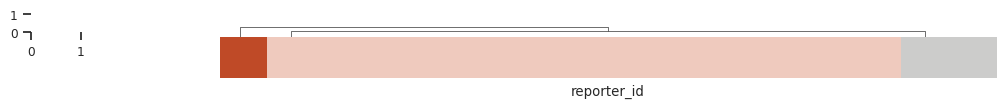

In [82]:
i = "CREB1"

cDNA_df_confidence_example = cDNA_df_confidence2[cDNA_df_confidence2['tf'] == i].copy()
cDNA_df_confidence_example = cDNA_df_confidence_example[['reporter_id', 'cor_pval', 'reporter_dif_minP', 'reporter_activity_minP', 'off_target_activity', 
                                                         'quality_score', 'conf_level', 'pval_adj', 'commercial_reporter', 'perturbation_condition', 
                                                         'off_target_perturbation', 'condition', 'tf']].drop_duplicates()

y_order = cDNA_df_confidence_example.sort_values(['conf_level', 'quality_score'], ascending=[False, False])[['reporter_id']].drop_duplicates()


from matplotlib.colors import ListedColormap

confidence_colors = {0: '#CCCCCB', 1: '#EFCABE', 2: '#E7A08B', 3: '#DD6840', 4: '#BF4A27'}
cmap = ListedColormap([confidence_colors[i] for i in range(len(confidence_colors))])

        
plot_scores2 = cDNA_df_confidence_example[['reporter_id', 'conf_level']].drop_duplicates().set_index('reporter_id')
        
plot_scores3 = plot_scores2.T[y_order['reporter_id']].T

n_conf_levels = len(cDNA_df_confidence_example['conf_level'].unique())


plot_1 = sns.clustermap(plot_scores3.T, row_cluster=False, col_cluster=True, row_colors=None,  
                                cmap=cmap, cbar=False, figsize=(10, 1), 
                                linewidths=0, linecolor='black',  cbar_kws={'ticks': []}, 
                                xticklabels=False, yticklabels=False, method='ward')
hc = plot_1.dendrogram_col
        
hc['leaves'] = np.arange(len(plot_scores3.columns))

plot_1 = sns.clustermap(plot_scores3.T, row_cluster=False, col_cluster=hc, row_colors=None,  
                                cmap=cmap, cbar=False, figsize=(10, 1), 
                                linewidths=0, linecolor='black',  cbar_kws={'ticks': []}, 
                                xticklabels=False, yticklabels=False, method='ward')



In [26]:
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Create a list to store the plots
plot_list_print = []

# Get unique TFs from cDNA_df_confidence2
unique_tfs = cDNA_df_confidence2['tf'].unique()

# Loop through each TF
for i in unique_tfs:
    # Generate a data frame with all reporters for a given TF
    cDNA_df_confidence_example = cDNA_df_confidence2[cDNA_df_confidence2['tf'] == i].copy()
    cDNA_df_confidence_example = cDNA_df_confidence_example[['reporter_id', 'cor_pval', 'reporter_dif_minP', 'reporter_activity_minP', 'off_target_activity', 
                                                             'quality_score', 'conf_level', 'pval_adj', 'commercial_reporter', 'perturbation_condition', 
                                                             'off_target_perturbation', 'condition', 'tf']].drop_duplicates()
    
    # Only do this for TFs with at least 10 reporters
    if len(cDNA_df_confidence_example) > 10:
        # Order reporters by confidence level and quality score
        y_order = cDNA_df_confidence_example.sort_values(['conf_level', 'quality_score'], ascending=[False, False])[['reporter_id']].drop_duplicates()
        
        # Plot the confidence levels of each reporter on top
        confidence_colors = {'0': '#CCCCCB', '1': '#EFCABE', '2': '#E7A08B', '3': '#DD6840', '4': '#BF4A27'}
        
        plot_scores2 = cDNA_df_confidence_example[['reporter_id', 'conf_level']].drop_duplicates().set_index('reporter_id')
        
        plot_scores3 = plot_scores2.T[y_order['reporter_id']].T
        
        n_conf_levels = len(cDNA_df_confidence_example['conf_level'].unique())
        
        plot_1 = sns.clustermap(plot_scores3, row_cluster=False, col_cluster=True, row_colors=None, col_colors=None, 
                                cmap=ListedColormap(list(confidence_colors.values())), cbar=False, figsize=(10, 10), 
                                dendrogram_ratio=0, dendrogram_side='right', linewidths=0, linecolor='black', 
                                xticklabels=False, yticklabels=False, cbar_kws={'ticks': []}, 
                                col_colors=[confidence_colors[str(level)] for level in plot_scores3.columns])
        
        hc = plot_1.dendrogram_col
        
        hc['leaves'] = np.arange(len(plot_scores3.columns))
        
        plot_1 = sns.clustermap(plot_scores3, row_cluster=False, col_cluster=hc, row_colors=None, col_colors=None, 
                                cmap=ListedColormap(list(confidence_colors.values())), cbar=False, figsize=(10, 10), 
                                dendrogram_ratio=0, dendrogram_side='right', linewidths=0, linecolor='black', 
                                xticklabels=False, yticklabels=False, cbar_kws={'ticks': []}, 
                                col_colors=[confidence_colors[str(level)] for level in plot_scores3.columns])
        
        hc = plot_1.dendrogram_col
        
        # Plot the actual scores underlying the confidence levels underneath
        x_order = ['Reporter activity', 'TPM correlation', 'Perturbation FC', 'Off-target activity']
        
        plot_activities2 = cDNA_df_confidence_example[['reporter_id', 'reporter_activity_minP', 'cor_pval', 'off_target_activity', 'reporter_dif_minP']].copy()
        plot_activities2 = plot_activities2.pivot(index='reporter_id', columns=None, values=['reporter_activity_minP', 'cor_pval', 'off_target_activity', 'reporter_dif_minP'])
        plot_activities2 = plot_activities2.T[y_order['reporter_id']].T
        plot_activities2 = plot_activities2.reindex(x_order)
        
        plot_2 = sns.clustermap(plot_activities2, row_cluster=False, col_cluster=hc, row_colors=None, col_colors=None, 
                                cmap=ListedColormap(sns.color_palette("RdBu_r", 100)), cbar=False, figsize=(10, 10), 
                                dendrogram_ratio=0, dendrogram_side='right', linewidths=0, linecolor='black', 
                                xticklabels=False, yticklabels=False, cbar_kws={'ticks': []})
        
        hc = plot_2.dendrogram_col
        
        # Now plot the features of the reporters at the bottom
        x_order2 = ['Promoter', 'Spacer length', 'Spacer sequence', 'Distance', 'Published/synthetic']
        
        feature_colors2 = {'hBGm': 1, 'mCMV': 2, 'minP': 3, 'Random': 4, '1': 5, '2': 6, '3': 7, '21bp': 8, '10bps': 9,
                           '5bp': 10, '10bp': 11, 'romanov': 12, 'TF-seq': 13, 'long': 14, 'promega': 15, 'TF-seq2': 16, 
                           'TF-seq3': 17, 'promega2long': 18, 'promega2': 19, '': 20}
        
        plot_features2 = cDNA_df_confidence_example.merge(reporter_features, on='reporter_id', how='left')
        plot_features2['distance'] = plot_features2['distance'].replace({'10bp': '10bps'})
        plot_features2 = plot_features2[['reporter_id', 'promoter', 'spacing', 'background', 'distance', 'commercial_reporter_source']].drop_duplicates()
        plot_features2 = plot_features2.pivot(index=None, columns='reporter_id', values=['promoter', 'spacing', 'background', 'distance', 'commercial_reporter_source'])
        plot_features2 = plot_features2.T[y_order['reporter_id']].T
        plot_features2 = plot_features2.reindex(x_order2)
        plot_features2 = plot_features2.replace(feature_colors2)
        
        breaks = np.arange(21)
        colors = ['#B4B4B4', '#231F20', '#CCCCCC', '#F3F3F3', '#EFCABD', '#E7A08B', '#DD6C48', '#A4A48C', '#D1D0C3',
                  '#BFD0D9', '#7D9EB2', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'white']
        
        plot_3 = sns.clustermap(plot_features2, row_cluster=False, col_cluster=hc, row_colors=None, col_colors=None, 
                                cmap=ListedColormap(colors), cbar=False, figsize=(10, 10), dendrogram_ratio=0, 
                                dendrogram_side='right', linewidths=0, linecolor='black', xticklabels=False, 
                                yticklabels=False, cbar_kws={'ticks': []}, breaks=breaks, na_colors='white')
        
        # Add some labeling at the very top
        condition2 = cDNA_df_confidence_example['condition'].str.extract(r'(.*)_.*')[0]
        title = plt.text(0.5, 0.97, f"TF = {i}\nPerturbation Condition = {cDNA_df_confidence_example['perturbation_condition'].unique()[0]}\n"
                                    f"Off target perturbation condition = {cDNA_df_confidence_example['off_target_perturbation'].unique()[0]}\n"
                                    f"Cell type = {condition2.unique()[0]}\n", transform=plt.gcf().transFigure, 
                                    fontsize=10, ha='center', va='top')
        
        # Combine the three heatmaps into one plot
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(4, 1, height_ratios=[1, 3, 0.5, 0.5])
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2])
        ax4 = plt.subplot(gs[3])
        
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        
        ax1.add_artist(title)
        ax2.imshow(plot_1.data2d, cmap=plot_1.cmap, aspect='auto')
        ax3.imshow(plot_2.data2d, cmap=plot_2.cmap, aspect='auto')
        ax4.imshow(plot_3.data2d, cmap=plot_3.cmap, aspect='auto')
        
        plot_list_print.append(fig)


SyntaxError: keyword argument repeated: col_colors (383481839.py, line 37)